[View in Colaboratory](https://colab.research.google.com/github/jpskycak/research_notebooks/blob/master/modeling_programmable_self_assembly_with_cellular_automata.ipynb)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
  
def linf_distance((a,b),(x,y)):
  return max(abs(a-x),abs(b-y))
def l1_distance((a,b),(x,y)):
  return abs(a-x)+abs(b-y)
def displacement(initial,terminal):
  return (terminal[0]-initial[0], terminal[1]-initial[1])
def get_coordinates(array):
  return [(i,j) for i,row in enumerate(array) for j,val in enumerate(row) if val==1]
def arrow(direction):
  # arrows: http://xahlee.info/comp/unicode_arrows.html
  arrowdict = {'(-1, 0)':'🡑',
              '(-1, 1)':'🡕',
              '(0, 1)':'🡒',
              '(1, 1)':'🡖',
              '(1, 0)':'🡓',
              '(1, -1)':'🡗',
              '(0, -1)':'🡐',
              '(-1, -1)':'🡔'}
  return arrowdict[str(direction)]
  
class Agents:
  
  ##########################
  ### PLOTTING / LOGGING ###
  ##########################
  
  def make_grid(self,highlight_agents_by_index=[],gradient=True):
    grid = np.ones((self.grid_shape[0],self.grid_shape[1],3))
    for p in self.template_coordinates:
      grid[p][0] = 1
      grid[p][1] = 1
      grid[p][2] = 125
      
    if gradient:
      max_gradient = max(self.gradient)
      for i,p in enumerate(self.agent_coordinates):
        val = 100+ 100*(1 - float(max_gradient - self.gradient[i])/max_gradient)
        grid[p][0] = val
        grid[p][1] = val
        grid[p][2] = val
        if self.activity[i] == False:
          grid[p][2] = 1
        if i in highlight_agents_by_index:
          grid[p][1] = 1
    else:
      for i,p in enumerate(self.agent_coordinates):
        grid[p][0] = 200
        grid[p][1] = 200
        grid[p][2] = 200
        if self.activity[i] == False:
          grid[p][2] = 1
        if i in highlight_agents_by_index:
          grid[p][1] = 1
        
    return grid
  
  def update_logarray(self,highlight_agents_by_index=[]):
    grid = self.make_grid(highlight_agents_by_index=highlight_agents_by_index)
    self.logarray.append(grid)
    
  def plot(self,t=-1):
    grid = self.logarray[t]
    plt.imshow(grid)
    plt.grid(False)
    plt.show()
    print self.logstr[t]
  
  #########################
  ### UPDATES UTILITIES ###
  #########################
  
  def prospective_location(self,i):
    (x0,y0) = self.agent_coordinates[i]
    (dx,dy) = self.direction[i]
    (x,y) = (x0+dx,y0+dy)
    return (x,y)
  
  def linf_distance_to_template(self,p):
    return min([linf_distance(p,t) for t in self.template_coordinates])
  
  def angle(self,i,p):
    p_direction = displacement(self.agent_coordinates[i],p)
    return l1_distance(self.direction[i],p_direction)
  
  def choose(self,i,plist):
    if len(plist) == 1:
      return plist[0]
    elif len(plist) >= 2:
      angles = [self.angle(i,p) for p in plist]
      leastangle = min(angles)
      plist = [plist[j] for j,a in enumerate(angles) if a==leastangle]
      if len(plist) == 1:
        return plist[0]
      else:
        distances = [self.linf_distance_to_template(p) for p in plist]
        leastdist = min(distances)
        plist = [plist[j] for j,d in enumerate(distances) if d==leastdist]
        if len(plist) == 1:
          return plist[0]
        elif len(plist) >= 2:
          return random.choice(plist)
  
  def surroundings(self,i):
    (x0,y0) = self.agent_coordinates[i]
    coordinates = [(x0-1,y0),(x0-1,y0+1),(x0,y0+1),(x0+1,y0+1),(x0+1,y0),(x0+1,y0-1),(x0,y0-1),(x0-1,y0-1)]
    ans = [{'coordinates': (x,y),
            'is_unoccupied': (x,y) not in self.agent_coordinates,
            'is_in_template': (x,y) in self.template_coordinates,
            'is_in_grid': x in range(self.grid_shape[0]) and y in range(self.grid_shape[1])} for (x,y) in coordinates]
    return ans
  
  def edgefollows(self,i):
    surr = self.surroundings(i)
    o = [s['is_unoccupied'] for s in surr]
    ans = []
    for k in range(8):
      o0, o1, o2, o3, o4, o5, o6, o7 = o[(k+0)%8], o[(k+1)%8], o[(k+2)%8], o[(k+3)%8], o[(k+4)%8], o[(k+5)%8], o[(k+6)%8], o[(k+7)%8]
      x0, x1, x2, x3, x4, x5, x6, x7 = not o0, not o1, not o2, not o3, not o4, not o5, not o6, not o7
      if o0 and o1 and o2 and o3:
        if x4 and x5 and x6 and x7:
          #  x  x  x
          #  x     o*
          #  o* o  o
          ans = [surr[(k+0)%8]['coordinates'],surr[(k+3)%8]['coordinates']]
          break
        elif o4 and x5 and x6 and x7:
          #  x  x  o*   x  x  x
          #  x     o    o*    o*
          #  o* o  o    o  o  o
          ans = [surr[(k+0)%8]['coordinates'],surr[(k+4)%8]['coordinates']]
          break
        elif o4 and o5 and x6 and x7:
          #  x  x  o*
          #  o*    o
          #  o  o  o
          ans = [surr[(k+0)%8]['coordinates'],surr[(k+5)%8]['coordinates']]
          break
        elif o4 and o5 and o6 and x7:
          #  x  o* o
          #  o*    o
          #  o  o  o
          ans = [surr[(k+0)%8]['coordinates'],surr[(k+6)%8]['coordinates']]
          break
      elif o0 and o1 and x3 and x4 and o5 and x6:
        #  o  e  x
        #  o     o*
        #  e  x  x
        ans = [surr[(k+5)%8]['coordinates']]
        break
      elif o0 and x1 and x2 and x3 and o4 and x5 and x6 and x7:
        #  x  x  x
        #  o*    o*
        #  x  x  x
        ans = [surr[(k+0)%8]['coordinates'],surr[(k+4)%8]['coordinates']]
        break
    surr_in_grid = [s['coordinates'] for s in surr if s['is_in_grid']]
    ans = [p for p in ans if p in surr_in_grid]
    return ans
  
  ###############
  ### UPDATES ###
  ###############
  
  def update_direction_coordinates(self,i):
    if self.activity[i]: # forward edge-follow
      p = self.prospective_location(i)
      plist = self.edgefollows(i)
      if p in plist:
        self.agent_coordinates[i] = p
      elif len(plist)>0: # turn & edge-follow
        p = self.choose(i,plist)
        self.direction[i] = displacement(self.agent_coordinates[i],p)
        self.update_activity(i)
        if self.activity[i]:
          self.agent_coordinates[i] = p
  
  def get_neighbors(self,i):
    p0 = self.agent_coordinates[i]
    return [j for j,p in enumerate(self.agent_coordinates) if linf_distance(p0,p)==1 and i!=j]
  
  def update_neighbors(self):
    self.neighbors = [self.get_neighbors(i) for i in range(len(self.agent_coordinates))]
    
  def update_gradient(self):
    self.gradient = ['' for _ in self.agent_coordinates]
    i_source = self.is_source.index(True)
    self.gradient[i_source] = 0
    for j in self.neighbors[i_source]:
      self.gradient[j] = 1
    while '' in self.gradient:
      for i,g in enumerate(self.gradient):
        if g=='':
          min_gradient_in_neighbors = 10**10 # big number
          should_assign_gradient_value = False
          for j in self.neighbors[i]:
            if self.gradient[j] != '':
              min_gradient_in_neighbors = min(self.gradient[j],min_gradient_in_neighbors)
              should_assign_gradient_value = True
          if should_assign_gradient_value:
            self.gradient[i] = 1+min_gradient_in_neighbors
            
  def update_activity(self,i):
    if self.activity[i]:
      p0 = self.agent_coordinates[i]
      p = self.prospective_location(i)
      if p0 in self.template_coordinates: # if inside the shape
        if p not in self.template_coordinates: # turn off if moving forward would leave the shape
          self.activity[i] = False
        inactive_neighbors = [j for j in self.neighbors[i] if self.activity[j]==False]
        if len(inactive_neighbors)>0:
          if any([self.gradient[i] == self.gradient[j] for j in inactive_neighbors]): # turn off if inactive neighbor has same gradient value
            self.activity[i] = False
    
  def update_activities(self):
    for i in range(len(self.agent_coordinates)):
      self.update_activity(i)
      
  def update_logstr(self,i,(p0,dir0,activity0,neighbors0,edgefollows0),(p1,dir1,activity1,neighbors1,edgefollows1)):
    dir0, dir1 = arrow(dir0), arrow(dir1)
    translation_dict = {True:'on',False:'off'}
    activity0, activity1 = translation_dict[activity0], translation_dict[activity1]
    template_string = 'Agent {0}: [{1},{2},{3}]-->[{4},{5},{6}]\nNeighbors: {7}\nEdgefollows: {8}'
    newstring = template_string.format(i,p0,dir0,activity0,p1,dir1,activity1,neighbors0,edgefollows0)
    self.logstr.append(newstring)
  
  ##########################
  ### DYNAMICS UTILITIES ###
  ##########################
  
  def init_template_coordinates(self):
    L = self.L
    template_array = np.zeros(self.grid_shape)
    template_array[2*L-1:3*L-1,2*L-1:3*L-1] = 1
    return get_coordinates(template_array)
  
  def init_agent_coordinates(self):
    L = self.L
    agents_array = np.zeros(self.grid_shape)
    agents_array[L:2*L,L:2*L] = 1
    return get_coordinates(agents_array)
  
  def init_activity(self):
    ans = [True for _ in self.agent_coordinates]
    ans[-1] = False
    return ans
  
  def init_direction(self):
    return [(1,0) for _ in self.agent_coordinates]
  
  def init_is_source(self):
    ans = []
    prod = [i*j for (i,j) in self.agent_coordinates]
    maxprod = max(prod)
    return [bool(p == maxprod) for p in prod]
    
  def get_logstr_params(self,i):
    p0, dir0, activity0 = self.agent_coordinates[i], self.direction[i], self.activity[i]
    neighbors0 = ' '.join([str(self.agent_coordinates[j]) for j in self.neighbors[i]])
    edgefollows0 = ' '.join([str(e) for e in self.edgefollows(i)])
    return (p0,dir0,activity0,neighbors0,edgefollows0)
  
  def move(self,i):
    orig_coordinates = self.agent_coordinates[i]
    self.update_direction_coordinates(i)
    self.update_neighbors()
    self.update_gradient()
    self.update_activities()
    if self.agent_coordinates[i] == orig_coordinates:
      return False
    else:
      return True
      
  ################
  ### DYNAMICS ###
  ################
  
  def __init__(self,L=5,scale=5):
    self.L = L
    self.scale = scale
    self.grid_shape = (scale*L, scale*L)
    self.template_coordinates = self.init_template_coordinates()
    self.agent_coordinates = self.init_agent_coordinates()
    self.activity = self.init_activity()    
    self.direction = self.init_direction()
    self.is_source = self.init_is_source()
    
    self.gradient = []
    self.update_neighbors()
    self.update_gradient() 
    
    self.logstr = []
    self.logarray = []
   
  def timestep(self,computation='parallel',log=True):
      
    subset = [i for i,a in enumerate(self.activity) if a==True]
    random.shuffle(subset)
    if computation=='parallel':
      for i in subset:
        if len(self.edgefollows(i))>0:
          if log:
            logstr_params0 = self.get_logstr_params(i)
            self.move(i)
            logstr_params1 = self.get_logstr_params(i)
            self.update_logstr(i,logstr_params0,logstr_params1)
            self.update_logarray(highlight_agents_by_index=[i])
          else:
            self.move(i)
    elif computation=='series':
      for i in [random.choice(subset)]:
        if len(self.edgefollows(i))>0:
          ans = True
          while ans:
            if log:
              logstr_params0 = self.get_logstr_params(i)
              ans = self.move(i)
              logstr_params1 = self.get_logstr_params(i)
              self.update_logstr(i,logstr_params0,logstr_params1) 
              self.update_logarray(highlight_agents_by_index=[i])
            else:
              self.move(i)
            
  def run(self,max_iter=1000,log_every=10,computation='parallel'):
    counter = 0
    tenth = int(float(max_iter)/10)
    tenths = 0
    print 'running...'
    while counter < max_iter:
      log = False
      if counter % log_every == 0:
        log=True
      if counter % tenth == 0:
        print('       ...'+str(tenths*10)+'%')
        tenths += 1
      a.timestep(computation=computation,log=log)
      counter += 1
      if set(a.agent_coordinates) == set(a.template_coordinates):
        self.update_logarray()
        print 'SUCCESS'
        break
      if counter == max_iter:
        print 'reached max iterations'

In [393]:
a = Agents(L=5)
a.run(max_iter=200,log_every=1,computation='parallel')

running...
       ...0%
       ...10%
       ...20%
SUCCESS


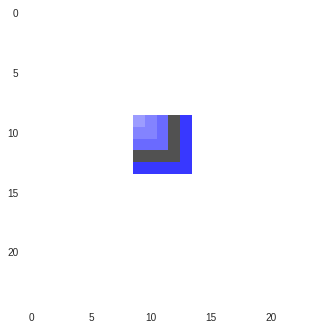

Agent 13: [(11, 8),🡓,on]-->[(12, 9),🡖,on]
Neighbors: (10, 9) (11, 9)
Edgefollows: (12, 9) (10, 8)


In [395]:
a.plot(-1)

In [0]:
# https://colab.research.google.com/notebooks/charts.ipynb#scrollTo=nv8P3UYm6SiQ

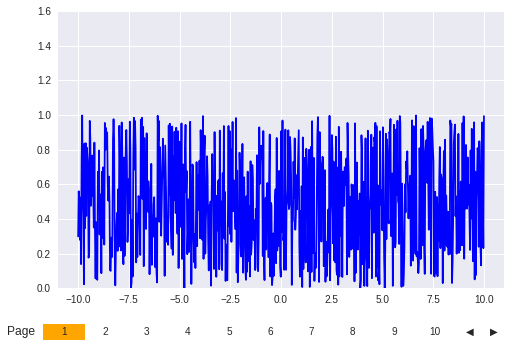

In [103]:
# https://stackoverflow.com/questions/41731102/matplotlib-display-only-one-graph-of-a-set-of-10-like-a-slideshow
import matplotlib.widgets
import matplotlib.patches
import mpl_toolkits.axes_grid1

class PageSlider(matplotlib.widgets.Slider):

    def __init__(self, ax, label, numpages = 10, valinit=0, valfmt='%1d', 
                 closedmin=True, closedmax=True,  
                 dragging=True, **kwargs):

        self.facecolor=kwargs.get('facecolor',"w")
        self.activecolor = kwargs.pop('activecolor',"b")
        self.fontsize = kwargs.pop('fontsize', 10)
        self.numpages = numpages

        super(PageSlider, self).__init__(ax, label, 0, numpages, 
                            valinit=valinit, valfmt=valfmt, **kwargs)

        self.poly.set_visible(False)
        self.vline.set_visible(False)
        self.pageRects = []
        for i in range(numpages):
            facecolor = self.activecolor if i==valinit else self.facecolor
            r  = matplotlib.patches.Rectangle((float(i)/numpages, 0), 1./numpages, 1, 
                                transform=ax.transAxes, facecolor=facecolor)
            ax.add_artist(r)
            self.pageRects.append(r)
            ax.text(float(i)/numpages+0.5/numpages, 0.5, str(i+1),  
                    ha="center", va="center", transform=ax.transAxes,
                    fontsize=self.fontsize)
        self.valtext.set_visible(False)

        divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
        bax = divider.append_axes("right", size="5%", pad=0.05)
        fax = divider.append_axes("right", size="5%", pad=0.05)
        self.button_back = matplotlib.widgets.Button(bax, label=ur'$\u25C0$', 
                        color=self.facecolor, hovercolor=self.activecolor)
        self.button_forward = matplotlib.widgets.Button(fax, label=ur'$\u25B6$', 
                        color=self.facecolor, hovercolor=self.activecolor)
        self.button_back.label.set_fontsize(self.fontsize)
        self.button_forward.label.set_fontsize(self.fontsize)
        self.button_back.on_clicked(self.backward)
        self.button_forward.on_clicked(self.forward)

    def _update(self, event):
        super(PageSlider, self)._update(event)
        i = int(self.val)
        if i >=self.valmax:
            return
        self._colorize(i)

    def _colorize(self, i):
        for j in range(self.numpages):
            self.pageRects[j].set_facecolor(self.facecolor)
        self.pageRects[i].set_facecolor(self.activecolor)

    def forward(self, event):
        current_i = int(self.val)
        i = current_i+1
        if (i < self.valmin) or (i >= self.valmax):
            return
        self.set_val(i)
        self._colorize(i)

    def backward(self, event):
        current_i = int(self.val)
        i = current_i-1
        if (i < self.valmin) or (i >= self.valmax):
            return
        self.set_val(i)
        self._colorize(i)

import numpy as np
from matplotlib import pyplot as plt


num_pages = 10
data = np.random.rand(700, num_pages)
spec = np.linspace(-10,10, 700)

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.18)
ax.set_ylim([0.,1.6])
line, = ax.plot(spec,data[:,0], color="b")

ax_slider = fig.add_axes([0.1, 0.05, 0.8, 0.04])
slider = PageSlider(ax_slider, 'Page', num_pages, activecolor="orange")

def update(val):
    i = int(slider.val)
    line.set_ydata(data[:,i])

slider.on_changed(update)

plt.show()